pybaseball github with install instructions: https://github.com/jldbc/pybaseball <br>
Documentation for pybaseball library: https://github.com/jldbc/pybaseball/tree/master/docs <br>
Statcast header meanings: https://baseballsavant.mlb.com/csv-docs

plate_x
Horizontal position of the ball when it crosses home plate from the catcher's perspective.

plate_z
Vertical position of the ball when it crosses home plate from the catcher's perspective.

In [1]:
import pybaseball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def batter(last_name, first_name):
    batter = pybaseball.playerid_lookup(last_name, first_name)
    return batter

In [3]:
def games_played_in_timeframe(first_name, last_name, start_date, end_date):
    l_name = last_name
    f_name = first_name
    batter_data = batter(l_name, f_name)
    batter_id = str(batter_data['key_mlbam'][0])
    batter_data = pybaseball.statcast_batter(start_date, end_date, batter_id)
    dates = list(Counter(batter_data['game_date']))
    clean_period = []
    for x in dates:
        date_split = x.split('-')
        day = date_split[2]
        if day[0] == '0':
            day = day[1]
            date_split[2] = day
        date_clean = '-'.join(date_split)
        clean_period.append('-'.join(date_split))
    return clean_period

In [4]:
def batter_game_number(dates, team):
    months = {'Jan' : '01', 'Feb' : '02', 'Mar' : '03', 'Apr' : '04', 'May' : '05', 'Jun' : '06',
          'Jul' : '07', 'Aug': '08', 'Sep' : '09', 'Oct' : '10', 'Nov' : '11', 'Dec' : '12'}
    
    game_dates = []
    for x in dates:   
        game_date = x.split('-')
        year = game_date[0]
        game_date = game_date[1:]
        game_dates.append('-'.join(game_date))        
    
    batter_logs = pybaseball.team_game_logs(year, team, "batting")
    test = list(batter_logs['Date'])
    test = [i.split() for i in test]
    x = 0
    for ind in test:
        ind[0] = months.get(ind[0])
        new_string = '-'.join(ind)
        test[x] = new_string
        x+=1
    batter_logs['Date'] = test
    
    game_ids = []
    data = pybaseball.statcast(dates[0], dates[-1])
    for x in range(len(dates)):
        game = batter_logs.loc[batter_logs['Date'] == game_dates[x]].reset_index()
        game_data = data.loc[data['game_date'] == dates[x]]
        if len(game) > 0:
            if game['Home'][0] == True:
                batter_game_data = game_data.loc[game_data['away_team'] == team]
                game_pk = list(batter_game_data['game_pk'])
                game_ids.append(game_pk[0])
            else:
                batter_game_data = game_data.loc[game_data['home_team'] == team]
                game_pk = list(batter_game_data['game_pk'])
                game_ids.append(game_pk[0])
    return game_ids

In [5]:
def batter_game_complete_data(game_id, batter_id):
    data = pybaseball.statcast_single_game(game_id).reset_index(drop = True)
    batter_data = pd.DataFrame()
    for x in range(len(data)):
        if data['batter'][x] == batter_id:
            batter_data = batter_data.append(data.iloc[[x]])
    batter_data = batter_data.reset_index(drop = True)
    return batter_data

In [6]:
def pitch_summary(game_data):
    data = Counter(game_data['pitch_type'])
    return data

In [7]:
def player(first_name, last_name, start_date, end_date):
    player_info = pybaseball.playerid_lookup(last_name, first_name)
    if (player_info['mlb_played_last'][0] - player_info['mlb_played_first'][0]) < 10:
        start_year = int(player_info['mlb_played_first'][0])
    else:
        start_year = int(player_info['mlb_played_last'][0] - 10)
        
    player_id = player_info['key_mlbam'][0]
    player_info = [player_id,start_year,str(player_info['mlb_played_last'][0])]
    
    data = pybaseball.statcast_batter(start_dt = start_date, end_dt = end_date, player_id = player_info[0])
    data = data.reset_index(drop = True)
    return data

In [8]:
def ball_and_strike(game_data):
    balls = pd.DataFrame(columns = ['pitch_type', 'description'])
    strikes = pd.DataFrame(columns = ['pitch_type', 'description'])
    live = pd.DataFrame(columns = ['pitch_type', 'description'])
    k = 0
    for x in range(len(game_data)):
        if game_data['description'][x] == 'ball':
            details = game_data[['pitch_type','description', 'plate_x', 'plate_z']].iloc[[x]]
            balls = balls.append(details)
        elif game_data['description'][x] == 'hit_into_play':
            details = game_data[['pitch_type','description', 'plate_x', 'plate_z']].iloc[[x]]
            live = live.append(details)
        else:
            details = game_data[['pitch_type','description', 'plate_x', 'plate_z']].iloc[[x]]
            strikes = strikes.append(details)
    return balls, strikes, live

In [9]:
def pitch_graph(pitching_breakdowns, start_date, end_date):
    pitch_ball = pitching_breakdowns[0]
    balls_xs = [x for x in pitch_ball['plate_x'].reset_index(drop = True)]
    balls_zs = [x for x in pitch_ball['plate_z'].reset_index(drop = True)]
    balls_colors = ['blue' for x in range(len(balls_xs))]

    pitch_strike = pitching_breakdowns[1]
    strikes_xs = [x for x in pitch_strike['plate_x'].reset_index(drop = True)]
    strikes_zs = [x for x in pitch_strike['plate_z'].reset_index(drop = True)]
    strikes_colors = ['red' for x in range(len(strikes_xs))]

    pitch_hit = pitching_breakdowns[2]
    hit_xs = [x for x in pitch_hit['plate_x'].reset_index(drop = True)]
    hit_zs = [x for x in pitch_hit['plate_z'].reset_index(drop = True)]
    hit_colors = ['green' for x in range(len(hit_xs))]


    xs = strikes_xs + balls_xs + hit_xs
    zs = strikes_zs + balls_zs + hit_zs
    colors = strikes_colors + balls_colors + hit_colors
    
    plt.title('All Pitches Thrown between ' + start_date + ' and ' + end_date)
    plt.scatter(xs,zs,color = colors)
    plt.show()

In [12]:
def main(first_name, last_name, start_date, end_date, team):
#     desired_batter = batter(last_name, first_name)
#     desired_batter_id = desired_batter['key_mlbam'][0]
    
#     games = games_played_in_timeframe(first_name, last_name, start_date, end_date)
    
#     game_id = batter_game_number(games, team)
    
#     game_batter_data = pd.DataFrame()
#     for x in game_id:
#         game_batter_data = game_batter_data.append(batter_game_complete_data(x, desired_batter_id))
#     game_batter_data = game_batter_data.iloc[::-1].reset_index(drop = True)
    
    player_data = player(first_name,last_name,start_date,end_date)
    pitch_breakdowns = ball_and_strike(player_data)
    pitch_graph(pitch_breakdowns, start_date, end_date)
#     return game_batter_data

Gathering Player Data


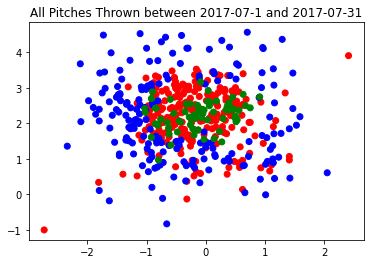

In [13]:
main('brett','gardner','2017-07-1','2017-07-31', 'NYY')